# Bursting the Burden Bubble?
### An Assessment of Sharma et al.'s Counterfactual-based Fairness Metric

This notebook shows the code used for the study 'Bursting the Burden Bubble?' by Sebastiaan Jans, Yochem van Rosmalen, Florian van der Steen, and Daan van der Weijden. It can be broken down into these parts:

0. Imports
1. Taiwan Data loading and preprocessing
2. Synthetic Data creation
3. Defining and training Classifiers OR loading them from checkpoints
4. Defining CERTIFAI and generating counterfactuals OR loading it from checkpoint
5. Burden results
6. Visualizations as used in the paper

### 0. Imports

All needed packages can easily be installed by uncommenting the `pip install` command below.

In [1]:
# !pip install -r 'requirements.txt' --quiet

In [1]:
from collections import namedtuple
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

from CERTIFAI import CERTIFAI

DATASET_NAMES = [
    'syndata-A',
    'syndata-B',
    'taiwan',
]
CERTIFAI_INPUT_DATA = dict(zip(DATASET_NAMES, (
    'data/syndata-A.csv',
    'data/syndata-B.csv',
    'data/taiwan.csv',
)))
MODEL_PATHS = dict(zip(DATASET_NAMES, (
    'models/LR-syndata-A.pt',
    'models/LR-syndata-B.pt',
    'models/LR-taiwan.pt',
)))
CERTIFAI_PICKLES = dict(zip(DATASET_NAMES, (
    'models/cert-syndata-A.pt',
    'models/cert-syndata-B.pt',
    'models/cert-taiwan.pt',
)))

/Users/yochem/.local/share/pyenv/versions/hcml/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Taiwan Data Loading and Preprocessing

In [2]:
def sample_taiwan(N=1000):
    # load original dataset
    taiwan_input = pd.read_csv('data/taiwan-original.csv')

    # create subset of data, N for size of subset
    taiwan_input_N = taiwan_input.sample(N, random_state=34)

    # reset indices
    taiwan_input_N = taiwan_input_N.reset_index(drop=True)

    # store sensitive attribute and labels
    taiwan_sex = taiwan_input_N['SEX'].copy().to_numpy()
    taiwan_labels = taiwan_input_N['default payment next month'].copy().to_numpy()

    # dataframe without ID column and no sensitive features
    taiwan_input_N = taiwan_input_N.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE'], axis=1)

    # rename labels to y
    taiwan_input_N = taiwan_input_N.rename(columns={'default payment next month': 'y'})

    # write subset of taiwan dataset, without sensitive attributes but with labels, to csv
    taiwan_input_N.to_csv(CERTIFAI_INPUT_DATA['taiwan'], index=False)
    # ensure last column is labels and second-last is sex, more precisely 's'
    taiwan_input_N = taiwan_input_N.drop('y', axis=1)
    taiwan_input_N['s'] = taiwan_sex % 2
    taiwan_input_N['y'] = taiwan_labels

    # convert to numpy
    taiwan_input = taiwan_input_N.to_numpy()

# sample_taiwan()
taiwan_ds = pd.read_csv(CERTIFAI_INPUT_DATA['taiwan'], index_col=0).values
taiwan_input, taiwan_labels = np.split(taiwan_ds, [-1], axis=1)
taiwan_labels = taiwan_labels.reshape(-1)

### 2. Synthetic Data Creation

The synthetic datasets are created using Numpy's random.normal() method.

In [3]:
def shifted_random_normal(locs, scale=1, *, sizes=80):
    """
    Return an array of normally distributed random numbers around
    loc with scale. The length of the array is N. Setting scale
    to 0 returns exactly the values of locs.
    """
    # all instances of even size
    if isinstance(sizes, int):
        sizes = [sizes//len(locs)] * len(locs)

    assert len(sizes) == len(locs) and all([isinstance(s, int) for s in sizes])

    parts = [np.random.normal(loc=loc, scale=scale, size=ps) for loc, ps in zip(locs, sizes)]
    return np.concatenate(parts)

def dataset_to_csv(X, y, filename):
    """
    Convert dataset in CERTIFAI approved csv format and write to file.
    """
    dataset = pd.DataFrame(np.insert(X[:,:2], 2, y, axis=1), columns=('x1', 'x2', 'y'))
    # certifai had to make sure these were classes, not numbers
    dataset.y = np.where(dataset.y == 0, 'a', 'b')
    dataset.to_csv(filename, header=True, index=False)

#### 2.2 Creating dataset $D_A$

In [4]:
def create_DA():
    x_1 = shifted_random_normal([1, 3.5, 9, 9])
    x_2 = shifted_random_normal([9, 5, 1, 1])

    # scale=0 makes sure it only draws the exact given number
    # so it works the same as e.g. np.ones() * number
    s = shifted_random_normal([0, 1, 0, 1], scale=0)
    labels = shifted_random_normal([0, 1], scale=0)
    return np.column_stack((x_1, x_2, s)), labels

# DA_input, DA_labels = create_DA()
s = create_DA()[0][:,2]
DA = np.loadtxt(CERTIFAI_INPUT_DATA['syndata-A'], skiprows=1, dtype=object, delimiter=',')
DA[:,2] = np.where(DA[:,2] == 'a', 0, 1)
DA = DA.astype(float)
DA = np.insert(DA, 2, s, axis=1)
DA_input, DA_labels = np.split(DA, [-1], axis=1)
DA_labels = DA_labels.reshape(-1)

##### 2.2.1 Write synthetic dataset $D_A$ to file

In [5]:
# uncomment to write new D_A to file
# dataset_to_csv(X=DA_input, y=DA_labels, filename=CERTIFAI_INPUT_DATA['syndata-A'])

#### 2.3 Creating Dataset $D_B$

In [6]:
def create_DB():
    x_1 = shifted_random_normal([1, 3.5, 9, 9], sizes=[15, 15, 30, 20])
    x_2 = shifted_random_normal([9, 5, 1, 1], sizes=[15, 15, 30, 20])

    # scale=0 makes sure it only draws the exact given number
    # so it works the same as e.g. np.ones() * number
    s = shifted_random_normal([1, 0, 1, 0], scale=0, sizes=[15, 15, 30, 20])
    labels = shifted_random_normal([0, 1], scale=0, sizes=[30, 50])
    return np.column_stack((x_1, x_2, s)), labels

s = create_DB()[0][:,2]
DB = np.loadtxt(CERTIFAI_INPUT_DATA['syndata-B'], skiprows=1, dtype=object, delimiter=',')
DB[:,2] = np.where(DB[:,2] == 'a', 0, 1)
DB = DB.astype(float)
DB = np.insert(DB, 2, s, axis=1)
DB_input, DB_labels = np.split(DB, [-1], axis=1)
DB_labels = DB_labels.reshape(-1)

##### 2.3.1 Write synthetic dataset $D_B$ to file

In [7]:
# uncomment to write new D_B to file
# dataset_to_csv(X=DB_input, y=DB_labels, filename=CERTIFAI_INPUT_DATA['syndata-B'])

#### 2.4 Show Synthetic datasets

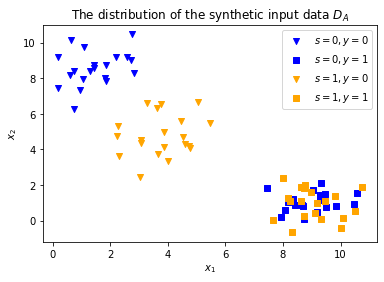

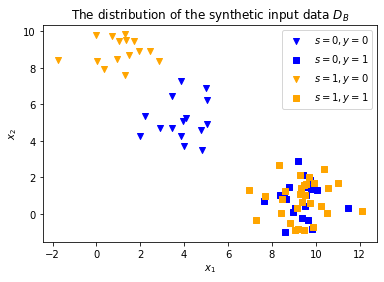

In [8]:
def show_synthetic_dataset(X, y, name):
    """
    Not pretty, but just to create an intuition for the data.
    """
    s0y0 = X[(X[:,2] == 0) & (y == 0)][:,:2]
    s0y1 = X[(X[:,2] == 0) & (y == 1)][:,:2]
    s1y0 = X[(X[:,2] == 1) & (y == 0)][:,:2]
    s1y1 = X[(X[:,2] == 1) & (y == 1)][:,:2]

    plt.scatter(s0y0[:,0], s0y0[:,1], color="blue", marker="v", label="$s=0,y=0$")
    plt.scatter(s0y1[:,0], s0y1[:,1], color="blue", marker="s", label="$s=0,y=1$")
    plt.scatter(s1y0[:,0], s1y0[:,1], color="orange", marker="v", label="$s=1,y=0$")
    plt.scatter(s1y1[:,0], s1y1[:,1], color="orange", marker="s", label="$s=1,y=1$")

    plt.title(f'The distribution of the synthetic input data ${name}$')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend(loc='upper right')
    plt.show()
    
show_synthetic_dataset(X=DA_input, y=DA_labels, name='D_A')
show_synthetic_dataset(X=DB_input, y=DB_labels, name='D_B')

### 3. Defining and Training Classifiers OR Loading them from Checkpoints

The CERTIFAI code prefers torch neural network modules. To make these module work like normal logistic regression models, we use one linear forward layer with a sigmoid activation.

In [9]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
        
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [10]:
def train_classifier(dataset, X, labels, epochs=2000, lr=1e-3, input_dim=2, output_dim=2):
    # !important: certifai expects the output to be one-hot encoded
    y = np.column_stack((np.where(labels == 0, 1, 0), np.where(labels == 1, 1, 0)))
    X_train = torch.Tensor(X)
    y_train = torch.Tensor(y)

    model = LogisticRegression(input_dim, output_dim)
    loss_fn = torch.nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    
    for _ in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = loss_fn(torch.squeeze(outputs), y_train)
        loss.backward()
        optimizer.step()

    pred = model(X_train)
    print(f'accuracy on training: {sum(pred.detach().argmax(axis=-1) == y_train.argmax(axis=-1)) / len(y_train)}')
    torch.save(model, MODEL_PATHS[dataset])
    
# train_classifier('syndata-A', DA_input[:,:2], DA_labels)
# train_classifier('syndata-B', DB_input[:,:2], DB_labels)
# train_classifier('taiwan', taiwan_input[:,:2], taiwan_labels)

In [11]:
def load_all_models():
    models = {}
    for ds, model in MODEL_PATHS.items():
        models[ds] = torch.load(model)
    return models

models = load_all_models()

### 4. Defining CERTIFAI and generating counterfactuals OR loading it from checkpoint

In [12]:
# TODO: delete?
def data_from_certifai(cert, inputs, target):
    df = cert.tab_dataset[inputs + [target]]
    model_input = cert.transform_x_2_input(df, pytorch=True)
    target = model_input[:,-1].long()
    predictors = model_input[:,:2]
    return torch.Tensor(predictors), torch.Tensor(target)

In [13]:
def train_certifai(model, dataname, model_input, protected_attribute, target):
    cert = CERTIFAI.from_csv(CERTIFAI_INPUT_DATA[dataname])
    cert.tab_dataset = cert.tab_dataset.drop(columns='y')
    cert.Population = 60000
    cert.fit(
        model,
        select_retain=10000,
        gen_retain=5000,
        model_input=torch.Tensor(model_input),
        generations=10,
        constrained=False,
        class_specific=0, # !important we only care about the unfavorable outcome
        verbose=True
    )
    # after fitting we can safely add back the protected attributes and targets
    cert.tab_dataset['s'] = protected_attribute
    cert.tab_dataset['favorable'] = target
    cert.classifier = model
    # !important nice to save the model within certifai
    # this makes sure the model's parameters (decisicion boundary) are saved with
    # the counterfactuals

    with open(CERTIFAI_PICKLES[dataname], 'wb') as f:
        pickle.dump(cert, f)

# train_certifai(models['syndata-A'], 'syndata-A', DA_input[:,:2], DA_input[:,2], DA_labels)
# train_certifai(models['syndata-B'], 'syndata-B', DB_input[:,:2], DB_input[:,2], DB_labels)
# train_certifai(models['taiwan'], 'taiwan', taiwan_input[:,:-2], taiwan_input[:,-2], taiwan_labels)

#### 4.2 Loading all pickled CERTIFAI class instances

In [14]:
def load_all_certs():
    certs = {}
    for ds, cert_pickle in CERTIFAI_PICKLES.items():
        with open(cert_pickle, 'rb') as f:
            certs[ds] = pickle.load(f)

    return certs
        
certs = load_all_certs()

### 5. Burden results

In [15]:
def show_burden(cert, protected_attr, unfavorable_target=0):
    """
    The check_fairness method of CERTIFAI is a bit weird. This function
    converts it to a more clear output. It also handles a very important
    thing, namely a bug in the CERTIFAI code. The code also calculates
    the burden of a group over the members with a favorable outcome.
    This should not be the case, and thus filters this function on
    `favorable=0'.
    """
    for attribute in protected_attr:
        possible_vals = set(cert.tab_dataset[attribute])
        fairness_checks = []
        for val in possible_vals:
            fairness_checks.append({attribute: val, 'favorable': unfavorable_target})
        
        fairness = cert.check_fairness(fairness_checks, normalised=True)
        change_name = lambda x: x.split('=')[1].split('-')[0]
        cols = list(map(change_name, fairness.keys()))
        column_names = pd.DataFrame(fairness.values(), index=cols, columns=(attribute,))
        return column_names.transpose()

print('syndata-A', show_burden(certs['syndata-A'], ['s']), sep='\n', end='\n\n')
print('syndata-B', show_burden(certs['syndata-B'], ['s']), sep='\n', end='\n\n')
print('taiwan', show_burden(certs['taiwan'], ['s']), sep='\n', end='\n\n')

syndata-A
           0        1
s  11.577682  4.64619

syndata-B
          0          1
s  3.307706  10.954803

taiwan
          0         1
s  1.428238  1.292059



### 6. Visualizations as used in the paper

The colored plots as well as the greyscale plots of the model's decision boundary, the counterfactuals and the original datapoints.

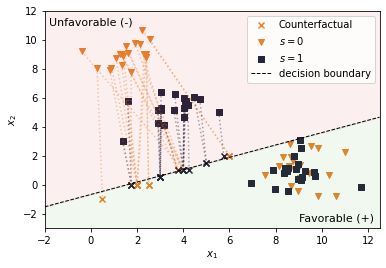

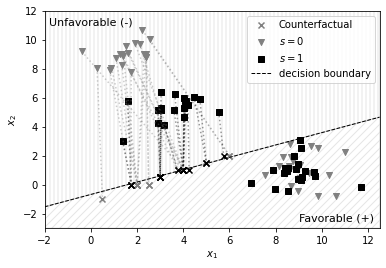

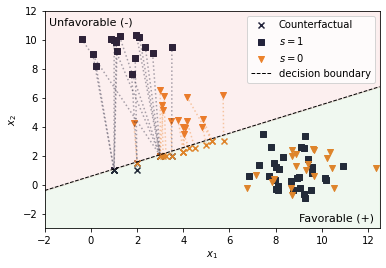

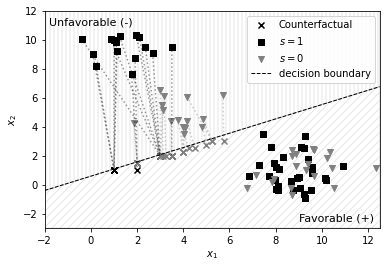

In [42]:
def plot_counterfactuals(cert, filename, bw=False):
    # og is original point, cf is its counterfactual
    for i, ((og, cf, _), (_, ds)) in enumerate(zip(cert.results, cert.tab_dataset.iterrows())):
        ognp = np.array(og)
        points = np.array([ognp[0], [cf[0][0], cf[0][1]]])
        # points = np.array([ognp[0]])
        if ds.s == 0:
            mark = 'v'
            color = '#EC822B' if not bw else 'grey'
        else:
            mark = 's'
            color = '#23233B' if not bw else 'black'

        # only plot CF's for unfavorable class
        if ds.favorable == 0:
            plt.plot(points[:,0], points[:,1], alpha=0.4, color=color, ls=':')
            plt.scatter(*points[1], marker='x', color=color, label='Counterfactual' if i == 0 else "")
        plt.scatter(*ognp[0], marker=mark, color=color, label=f'$s={int(ds.s)}$' if i in (0, 20) else "")

    ymin = -3
    ymax = 12

    xmin = -2
    xmax = 12.5
    
    # plot the decision boundary using model weights
    w1, w2 = cert.classifier.get_parameter('linear.weight')[0].detach().numpy()
    b = cert.classifier.get_parameter('linear.bias')[0].detach().numpy()
    x_dec_bound = [xmin, xmax]
    y_dec_bound = [(-b - 0.5 - x1 * w1) / w2 for x1 in [xmin, xmax]]
    
    plt.plot(x_dec_bound, y_dec_bound, 'k', lw=1, ls='--', label='decision boundary')
    if bw:
        plt.fill_between(x_dec_bound, y_dec_bound, ymin, hatch='///', alpha=0.1, color='white', edgecolor='black', zorder=0.5)
        plt.fill_between(x_dec_bound, y_dec_bound, ymax, hatch=r'|||', alpha=0.1, color='white', edgecolor='black', zorder=0.5)
    else:
        plt.fill_between(x_dec_bound, y_dec_bound, ymin, color='tab:green', alpha=0.07)
        plt.fill_between(x_dec_bound, y_dec_bound, ymax, color='tab:red', alpha=0.07)
    plt.text(xmax - 3.5, ymin + 0.5, 'Favorable (+)', fontsize=11)
    plt.text(xmin + 0.2, ymax - 1, 'Unfavorable (-)', fontsize=11)

    plt.ylim([ymin, ymax])
    plt.xlim([xmin, xmax])
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.legend()
    
    plt.savefig(filename, dpi=1200)
    plt.show()

plot_counterfactuals(certs['syndata-A'], filename='img/syndata-A.pdf')
plot_counterfactuals(certs['syndata-A'], filename='img/syndata-A-bw.pdf', bw=True)
plot_counterfactuals(certs['syndata-B'], filename='img/syndata-B.pdf')
plot_counterfactuals(certs['syndata-B'], filename='img/syndata-B-bw.pdf', bw=True)

In [43]:
def statistical_parity(model, input_df, inputs, sens_attr, favorable_target=1):
    """
    Calculate P[pred == 1 | sens_attr == 0] and P[pred == 1 | sens_attr == 1]
    and return these two values. pred is the prediction of the model.
    """
    df = input_df.copy()
    model_input = torch.Tensor(df.drop([sens_attr, 'favorable'], axis=1).to_numpy())
    df['pred'] = model(model_input).detach().numpy().argmax(axis=-1)
    if favorable_target == 0:
        return 1 - df[df[sens_attr] == 0].pred.mean(), 1 - df[df[sens_attr] == 1].pred.mean()
    return df[df[sens_attr] == 0].pred.mean(), df[df[sens_attr] == 1].pred.mean()

def add_dataset_row(table, model, cert, inputs, sens_attr, name, favorable_target=1):
    cols = table.columns
    
    # calculate statistical parity
    sp0, sp1 = statistical_parity(model, cert.tab_dataset, inputs, sens_attr, favorable_target)
    
    # calculate burden
    bu0, bu1 = show_burden(cert, sens_attr, 1 - favorable_target).to_numpy()[0]

    # construct row
    row = pd.DataFrame([[sp0, sp1, sp0 / sp1,
                         bu0, bu1, bu0 / bu1]],
                       columns=cols,
                       index=(name,))
    return table.append(row)

In [44]:
table = pd.DataFrame(columns=(
    'S=0',
    'S=1',
    'SP 0/1',
    'S=0',
    'S=1',
    'Burden 0/1'
))

taiwan_input_names = certs['taiwan'].tab_dataset.drop(['s','favorable'], axis=1).columns
table = add_dataset_row(table, models['taiwan'], certs['taiwan'], taiwan_input_names, 's', 'Taiwan', favorable_target=0)
table = add_dataset_row(table, models['syndata-A'], certs['syndata-A'], ['x1', 'x2'], 's', 'Syn. Data $D_A$')
table = add_dataset_row(table, models['syndata-B'], certs['syndata-B'], ['x1', 'x2'], 's', 'Syn. Data $D_B$')
table = table.round(3)

table.to_latex('img/table.tex') 
table


,S=0,S=1,SP 0/1,S=0,S=1,Burden 0/1
Taiwan,0.967,0.948,1.020,1.383,0.940,1.471
Syn. Data $D_A$,0.500,0.500,1.000,11.578,4.646,2.492
Syn. Data $D_B$,0.571,0.667,0.857,3.308,10.955,0.302
